<a href="https://colab.research.google.com/github/khldsqmr/Credit-Card-Fraud-Detection-EDA-Classification-algorithms/blob/main/Credit%20Card%20Fraud%20Detection%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses the Credit Card Fraud Detection dataset. Our aim is to get the sense of the distribution of the scaled variables provided in data, and deal with the imbalance class of data. 
We also aim at the trying out different classification models namely, Logistics regression, decision trees, etc., to compare and determine their accuracies using a Neural network.


Understand the little distribution of the "little" data that was provided to us.
Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm)
Determine the Classifiers we are going to use and decide which one has a higher accuracy.
Create a Neural Network and compare the accuracy to our best classifier.
Understand common mistaked made with imbalanced datasets.

In [29]:
# Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

# **Dataset**

In [30]:
# Importing dataset
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
# Checking for the missing values
df.isna().any().any()

False

In [32]:
# Check for the Class variable counts
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [33]:
ClassCount = df.Class.value_counts()
ClassCountPerc0 = round(ClassCount[0]/(ClassCount[0]+ClassCount[1]),5)
ClassCountPerc1 = round(ClassCount[1]/(ClassCount[0]+ClassCount[1]),5)
print("We have a total of ", ClassCountPerc0*100, "% of non-fraudulent, and ", ClassCountPerc1*100, "% of fraudulent transactions")

We have a total of  99.827 % of non-fraudulent, and  0.173 % of fraudulent transactions


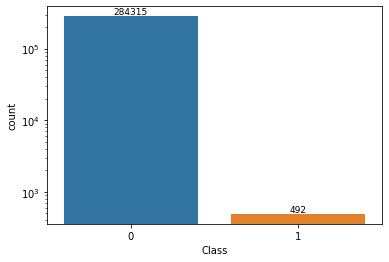

In [34]:
# Plotting the Counts of Class variable
ax=sns.countplot(x='Class',data=df);
ax.set_yscale('log')

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=9, color='black', ha='center', va='bottom')

Using the above plot, we get idea of how the Class variable is imbalanced. As evident, 284315 of the transactions are non-fraudulent in comparison to the 492 fraudulent transactions. 

Thus, if we develop a predictive model based on the imbalanced class data, we would not be able to correctly classify fraudulent and non-fraudulent tarnsactions, as our model would overfit the data, and classify most of the transactions as non-fraudulent.

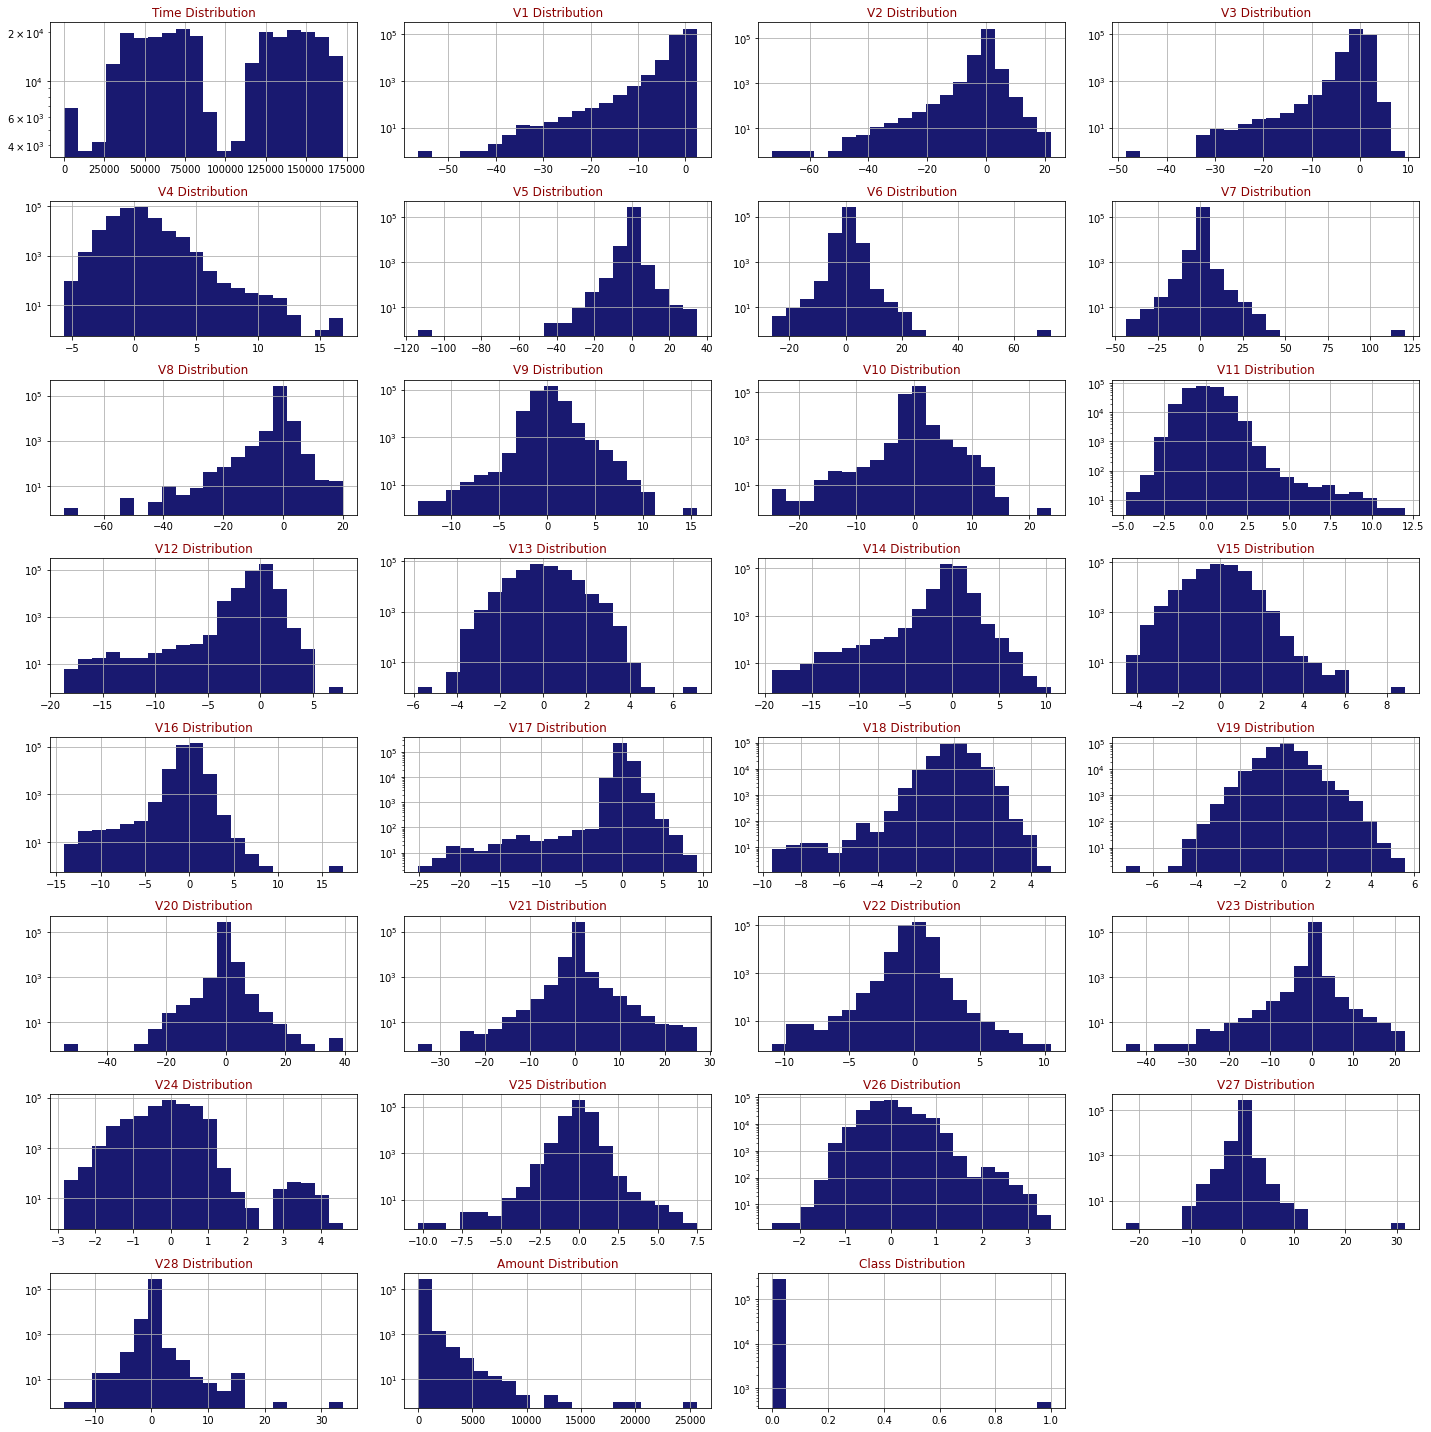

In [35]:
# Plotting the distribution of other variables
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,8,4)

Using the above plot, we are able to determine the distribution and skewness associated with each of the variables.

### **Scaling and Distributing the Time and Amount variables**

By scaling the Time and Amount variables, we will be able to get the scaled values for these features similar to the other V variables, and thus, makes it easier to perform our analysis on similar scale.

By distributing the variables, we aim at creating a sample dataset out of our original dataset, so that we get a balanced class of Fraudulent and non-Fraudulent data.

In [36]:
# We scale the columns that are not scaled i.e., Time and Amount
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler() # RobustScaler is less prone to outliers

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [37]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Thus, Time and Amount are scaled as shown above.

In case of unbalanced Class variable, we split the data using the stratified shuffle split, which means that each of the splitted data (strata) contains equal proporation of Class variable.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [39]:
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest  = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest  = original_ytest.values

# Check if the train & test label have similar distribution
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print("Train Set: ", train_counts_label/ len(original_ytrain))
print("Test Set:  ", test_counts_label/ len(original_ytest))

Label Distributions: 

Train Set:  [0.99827076 0.00172924]
Test Set:   [0.99827952 0.00172048]


### **Devising balanced sample data**

Here, we remove some of the data from having the majority class to create a sample data which has a balanced class. This technique is known as Random Under-Sampling. 

As per our observation, we have 492 fraudulent transactions, and thus, we gather 492 random non-fraudulent transactions to to have a normal distribution of the classes, as we have highly skewed classes. However, this technique doesn't represent the model of our actual data because we remove a large number of data to create a balanced sample data.






In [40]:
# Suffle the data
df = df.sample(frac=1)

# Gather 492 non-fraudulent classes
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

In [41]:
# Concatenate the fraudulent and non-fraudulent dataframes
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
209372,0.600713,0.620801,1.962877,-0.320360,-1.867450,0.298130,0.307475,-0.811258,0.409026,-0.248255,0.298796,0.281112,0.216640,0.346012,-1.121785,0.794216,-0.995098,-0.179310,-0.435151,-0.061915,0.654871,-0.154580,0.010006,0.026681,-0.034744,-0.455486,0.156079,0.567749,-0.119053,-0.083469,0
154670,1.145812,0.209084,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,-1.593249,-8.993811,7.864467,-10.649840,1.826591,-12.913632,-0.766330,-7.954098,-7.809635,-1.718511,3.832985,1.264954,1.089084,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,1
257577,0.041920,0.864037,2.203849,-0.723576,-1.636753,-1.200134,-0.026412,-0.417092,-0.401287,-0.213770,-0.901374,1.012909,0.798419,0.322803,1.050549,0.020780,-0.388034,1.197320,-0.336396,-0.726266,0.884314,0.097740,0.465529,1.309508,-0.065042,0.363879,0.276783,0.038753,-0.045023,-0.069535,0
15166,1.089779,-0.683384,-18.474868,11.586381,-21.402917,6.038515,-14.451158,-4.146524,-14.856124,12.431140,-4.053353,-9.040396,5.966203,-8.463966,0.078692,-9.092533,0.010822,-7.186376,-13.797475,-4.958494,1.321167,1.577924,1.741136,-1.251138,-0.396219,0.095706,1.322751,-0.217955,1.628793,0.482248,1
142557,4.643750,0.001140,-1.430864,-0.802529,1.123320,0.389760,-0.281214,-0.055123,1.326232,0.195700,-0.546890,-0.713474,1.274629,0.023682,-1.521696,0.727242,0.166505,0.348038,-0.566390,0.216016,-1.140376,0.634184,0.325575,0.014002,0.844946,0.114963,0.156365,-0.619437,-0.120351,0.035594,1


In [42]:
# Shape of the dataframe
new_df.shape

(984, 31)

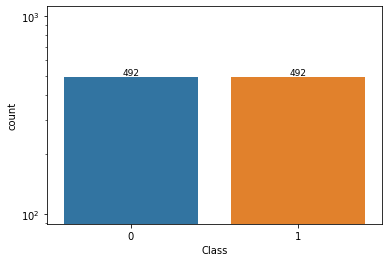

In [43]:
# Plotting the Counts of Class variable
ax=sns.countplot(x='Class',data=new_df);
ax.set_yscale('log')

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=9, color='black', ha='center', va='bottom')

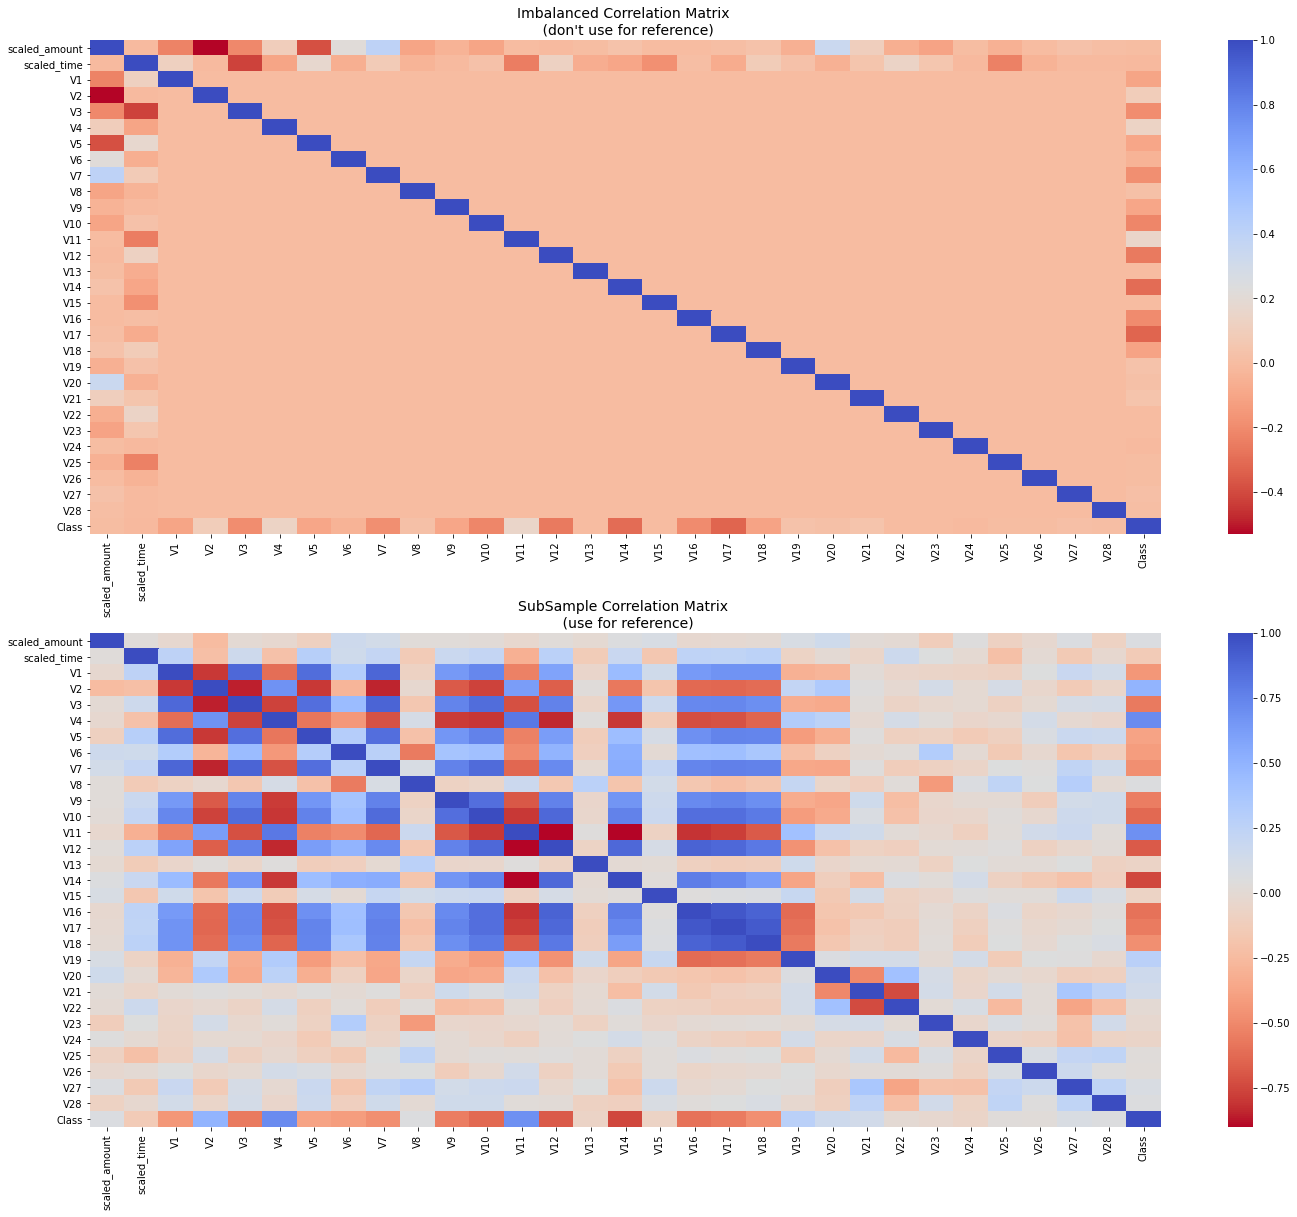

In [44]:
# Correlation Matrix to understand if the correlation influence our classification
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

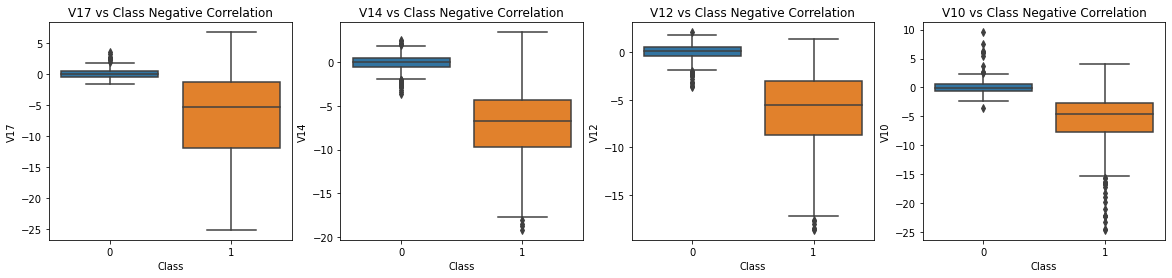

In [45]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

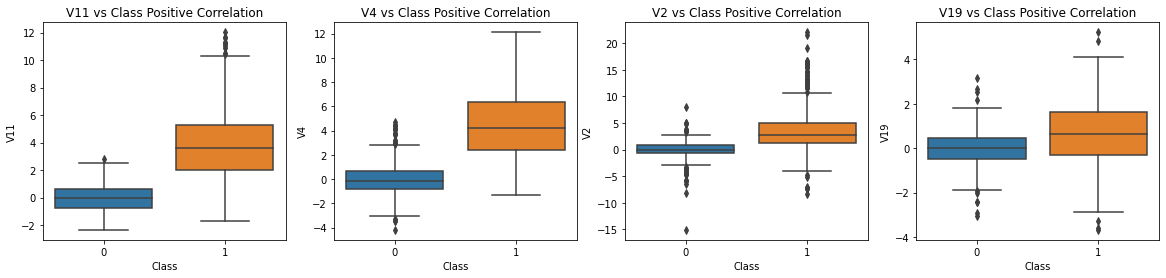

In [46]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

### **Outlier Removal**

We remove the outliers that have high correlation with our classes. This will have a positive impact on the accuracy of our models.

The possible technique to find out the outliers is using the Box and Whisker plots. But here, we have to determine the threshold to remove the outliers. For eg, the points outside the interquartile range are generally considered as the outliers. But not all of them are the outliers, and by removing all of these points, we will lose a lot of information. Thus, we determine a threshold (For eg, it could be determined by multiplying 1.5 with the interquartile range).

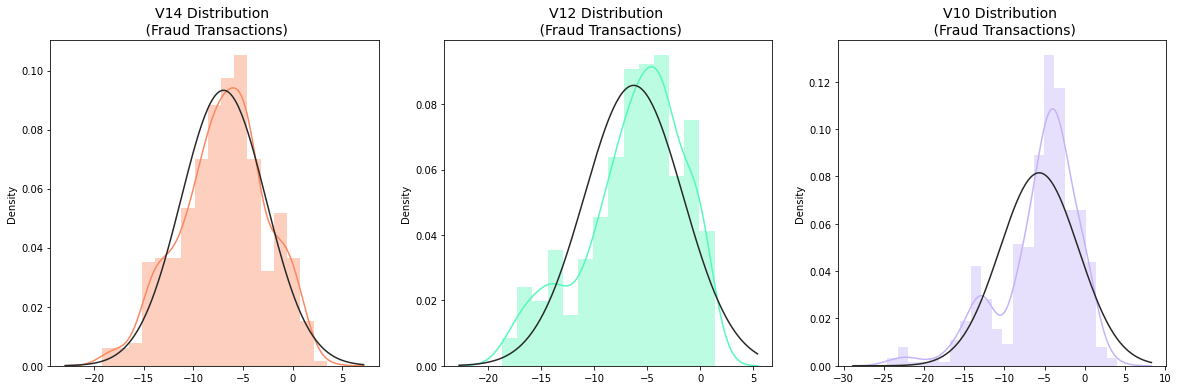

In [47]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [48]:
# V14 - Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25 :{} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr         :{}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off     :{}'.format(v14_cut_off))
print('V14 Lower   :{}'.format(v14_lower))
print('V14 Upper   :{}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)

Quartile 25 :-9.692722964972385 | Quartile 75: -4.282820849486866
iqr         :5.409902115485519
Cut Off     :8.114853173228278
V14 Lower   :-17.807576138200663
V14 Upper   :3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -18.049997689859396, -18.8220867423816, -19.2143254902614]


In [49]:
# V12 - Removing outliers 
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower    :{}'.format(v12_lower))
print('V12 Upper    :{}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers :{}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

V12 Lower    :-17.3430371579634
V12 Upper    :5.776973384895937
V12 outliers :[-18.683714633344298, -18.553697009645802, -18.047596570821604, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976


In [50]:
# V10 - Removing outliers
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower    :{}'.format(v10_lower))
print('V10 Upper    :{}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers :{}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

V10 Lower    :-14.89885463232024
V10 Upper    :4.920334958342141
V10 outliers :[-15.1237521803455, -16.6011969664137, -18.2711681738888, -16.7460441053944, -15.563791338730098, -18.9132433348732, -20.949191554361104, -15.2399619587112, -14.9246547735487, -22.1870885620007, -15.346098846877501, -15.2399619587112, -15.563791338730098, -16.2556117491401, -15.124162814494698, -16.3035376590131, -24.5882624372475, -14.9246547735487, -23.2282548357516, -15.2318333653018, -22.1870885620007, -16.6496281595399, -24.403184969972802, -17.141513641289198, -22.1870885620007, -19.836148851696, -22.1870885620007]
Feature V10 Outliers for Fraud Cases: 27
Number of Instances after outliers removal: 943


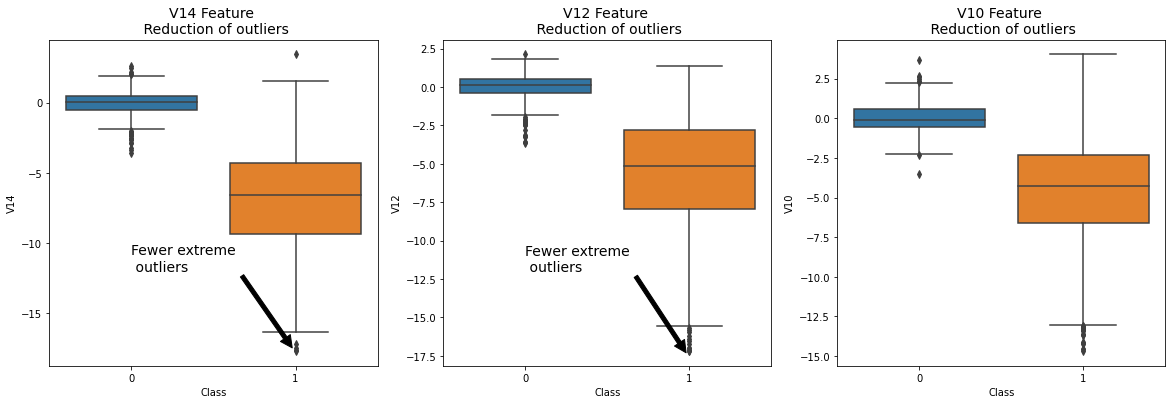

In [51]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)
# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)
# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)
plt.show()

Thus we have a balanced sample data which can be used for our further analysis. We aim at performing unsupervised and supervised algorithms on this data to detect anomalies, cluster the overall data and compare different classification algorithms.